In [1]:
import requests
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
collect_catalogus = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/'
collect_observations = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenWaarnemingen'
collect_latest_observations = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenLaatsteWaarnemingen'
collect_available_observations = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenAantalWaarnemingen'


In [3]:
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
resp = requests.post(collect_catalogus, json=request)
result = resp.json()
# print all variables in the catalogus
# print(result)

df_locations = pd.DataFrame(result['LocatieLijst']).set_index('Locatie_MessageID')
# load normalized JSON object (since it contains nested JSON)
df_metadata = pd.io.json.json_normalize(
    result['AquoMetadataLijst']).set_index('AquoMetadata_MessageID')

In [4]:
df_metadata[df_metadata['Grootheid.Code'] == 'WATHTE']


,Eenheid.Code,Eenheid.Omschrijving,Grootheid.Code,Grootheid.Omschrijving,Hoedanigheid.Code,Hoedanigheid.Omschrijving,Parameter_Wat_Omschrijving
AquoMetadata_MessageID,,,,,,,
13,cm,centimeter,WATHTE,Waterhoogte,MSL,t.o.v. Mean Sea Level,Waterhoogte Oppervlaktewater t.o.v. Mean Sea L...
60,cm,centimeter,WATHTE,Waterhoogte,PLAATSLR,t.o.v. plaatselijk referentievlak,Waterhoogte Oppervlaktewater t.o.v. plaatselij...
74,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...
102,cm,centimeter,WATHTE,Waterhoogte,TAW,t.o.v. Tweede Algemene Waterpassing,Waterhoogte Oppervlaktewater t.o.v. Tweede Alg...


In [5]:
df_metadata_locations = pd.DataFrame(result['AquoMetadataLocatieLijst'])
location_info = df_metadata_locations.merge(
    df_metadata, 
    left_on='AquoMetaData_MessageID', 
    right_index=True
).merge(
    df_locations, 
    left_on='Locatie_MessageID', 
    right_index=True
)


filtered = location_info[location_info.X >= -1e7]
filtered = filtered[filtered.X <= 2000000]

(-231543.35022288075, 1156298.0365094857, 5311905.587122518, 6942636.980037163)

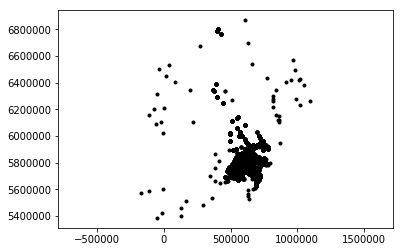

In [6]:
plt.plot(filtered.X, filtered.Y, 'k.')
plt.axis('equal')

In [30]:
{x for x in location_info.set_index('Code').index if x.startswith('IJ')}
location_info.set_index('Code').loc['IJMDBTHVN']

,AquoMetaData_MessageID,Locatie_MessageID,Eenheid.Code,Eenheid.Omschrijving,Grootheid.Code,Grootheid.Omschrijving,Hoedanigheid.Code,Hoedanigheid.Omschrijving,Parameter_Wat_Omschrijving,Coordinatenstelsel,Naam,X,Y
Code,,,,,,,,,,,,,
IJMDBTHVN,74,84132,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,25831,IJmuiden buitenhaven,605633.035699,5.813598e+06
IJMDBTHVN,35,84132,oC,graad Celsius,T,Temperatuur,NVT,Niet van toepassing,Temperatuur Oppervlaktewater oC,25831,IJmuiden buitenhaven,605633.035699,5.813598e+06
IJMDBTHVN,38,84132,cm,centimeter,WATHTBRKD,Waterhoogte berekend,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte berekend Oppervlaktewater t.o.v. N...,25831,IJmuiden buitenhaven,605633.035699,5.813598e+06


In [20]:
location_info[location_info.X > 2000000]

,AquoMetaData_MessageID,Locatie_MessageID,Eenheid.Code,Eenheid.Omschrijving,Grootheid.Code,Grootheid.Omschrijving,Hoedanigheid.Code,Hoedanigheid.Omschrijving,Parameter_Wat_Omschrijving,Code,Coordinatenstelsel,Naam,X,Y
3341,74,87878,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,EMPBNDN,25831,Empel beneden,6.681350e+06,886420.666850
5630,74,88729,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,ZWVTS16BNDN,25831,"Zuidwillemsvaart, sluis 16 beneden",6.594149e+06,933454.810685
7247,74,87884,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,HINTHBNDN,25831,Hintham beneden,6.674334e+06,889930.867310
8098,74,88725,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,ZWVTS16BVN,25831,"Zuidwillemsvaart, sluis 16 boven",6.594053e+06,932982.364822
9486,74,87874,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,EMPBVN,25831,Empel boven,6.681074e+06,886574.069444
10984,74,87881,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,HINTHBVN,25831,Hintham boven,6.673767e+06,890050.979369
741,85,85469,graad,graad,Th0,Gemiddelde golfrichting in het spectrale domein,WARNDN,t.o.v. ware Noorden,Gemiddelde golfrichting in het spectrale domei...,IJG2BI,25831,IJgeul 2 boei,6.829520e+06,666963.546639
6636,116,85469,cm,centimeter,HTE3,Significante deiningshoogte in het spectrale d...,NVT,Niet van toepassing,Significante deiningshoogte in het spectrale d...,IJG2BI,25831,IJgeul 2 boei,6.829520e+06,666963.546639
11004,39,85469,s,seconde,T1/3,Gem. golfperiode langste 1/3 deel v.d. golven ...,NVT,Niet van toepassing,Gem. golfperiode langste 1/3 deel v.d. golven ...,IJG2BI,25831,IJgeul 2 boei,6.829520e+06,666963.546639
2204,28,85469,cm,centimeter,H1/3,Gem. hoogte van hoogste 1/3 deel v.d. golven (...,NVT,Niet van toepassing,Gem. hoogte van hoogste 1/3 deel v.d. golven (...,IJG2BI,25831,IJgeul 2 boei,6.829520e+06,666963.546639


In [43]:
import osr
utm = osr.SpatialReference()
utm.ImportFromEPSG(25831)
rd = osr.SpatialReference()
rd.ImportFromEPSG(28992)
wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)

IJMDBTHVN = 605633.035699, 5.813598e+06
EMPBNDN =   6681350., 886420.666850

In [45]:
utm2wgs84 = osr.CoordinateTransformation(utm, wgs84)
rd2wgs84 = osr.CoordinateTransformation(rd, wgs84)
utm2wgs84.TransformPoint(*IJMDBTHVN), utm2wgs84.TransformPoint(*EMPBNDN)

((4.554823132120093, 52.462325179942695, -6.58305361866951e-05),
 (51.69112846673795, 5.290460749348417, -8.884817361831665e-07))

In [ ]:
utm2wgs84.TransformPoint()